# Voice detection

## 1) Fourier transform for spectral analysis

Frequency analysis is just another way of looking at the same data. Instead of observing the data in the time domain, frequency analysis decomposes time data in the series of sinus waves. Fast Fourier Transform (FFT) is a mathematical method for transforming a function of time into a function of frequency.

## 2) A code which draw power spectrum

We can see that women voices have higher frequency and higher power specturam than mans.

In [1]:
import scipy.io.wavfile
from scipy.io import wavfile
import math
import glob
import os
import numpy as np
from numpy import fft
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt

In [2]:
def show_plot(x_axis,y_axis):
    plt.plot(x_axis, y_axis)
    plt.xlim(0 , 1000)
    plt.xlabel('frequency')
    plt.ylabel('power spectrum')
    plt.show()

read audio file and take average of 2 channels. we devide it again by 2 for nyquist frequency. 
we calculate power spectrum as square of absolute value of discrete fourier transformation.
then we use frequency according to power and draw the plot with theese data.

with these plots we can see the power peak for frequencies in files. and with comparing these peaks with given ranges we can determine the gender.

In [3]:
def find_power_spectrum(file_name):
    sampling_rate, data = scipy.io.wavfile.read(file_name)
    sum_stereo = data.sum(axis=1) / 2
    freq_nq = len(sum_stereo) // 2
    power_spectrum = (abs(fft.fft(sum_stereo))[:freq_nq] / len(data) * 2) ** 2
    frequency = fft.fftfreq(len(data), 1 / sampling_rate)[:freq_nq]
    show_plot(frequency,power_spectrum)
    return (frequency, power_spectrum)


## 3) Find max frequency

Finding maximum of frequency using argmax function.

In [4]:
def max_freq(file_name):
    frequency, power_spectrum = find_power_spectrum(file_name)
    return frequency[np.argmax(power_spectrum)]
  

## 4) Women or men voice detection

We know women sound frequency is between 165 to 255 and men frequency is between 85 to 180.

### Improvements
we can only process 50-350 frequency range and calculate maximum.

In [5]:
def main(folder):
    output_vector = dict()
    for filename in glob.glob(os.path.join(folder, '*.wav')):
        max = max_freq(filename)
        women_or_men = 'man' if max<=180 else 'women'
        output_vector[filename] = [women_or_men,max]
        print(output_vector[filename])
        print('------------------------------------------')
    print(output_vector)


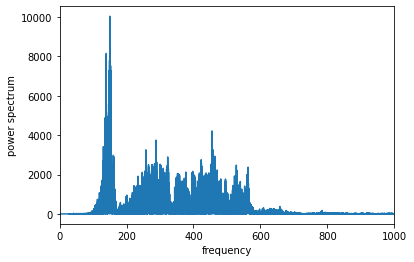

['man', 149.89958292986054]
------------------------------------------


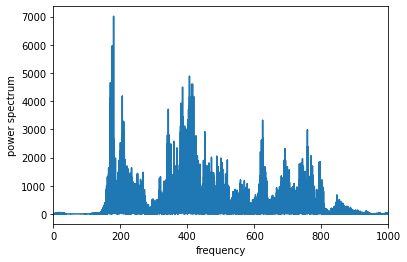

['women', 180.00235293348715]
------------------------------------------


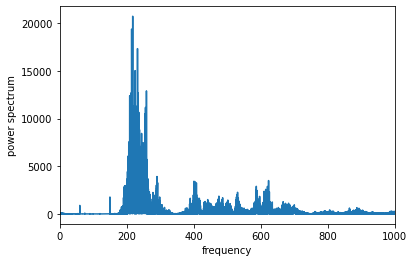

['women', 218.0506359746872]
------------------------------------------


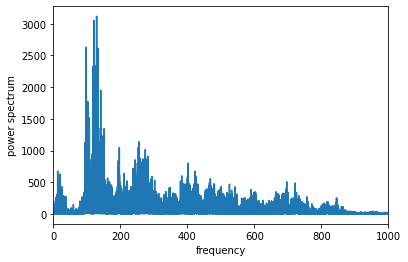

['man', 128.9516661222912]
------------------------------------------


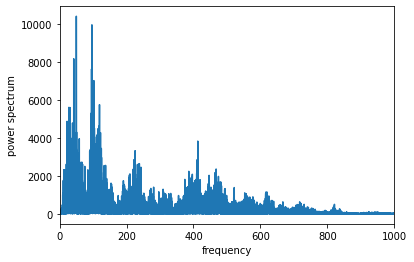

['man', 50.047482262404]
------------------------------------------


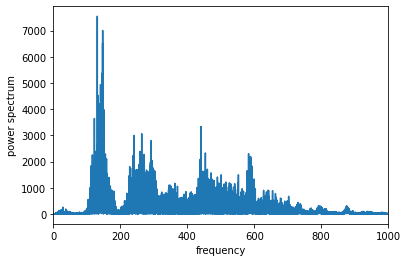

['man', 131.32155104194143]
------------------------------------------


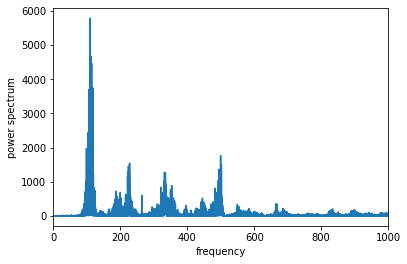

['man', 110.43235723920863]
------------------------------------------


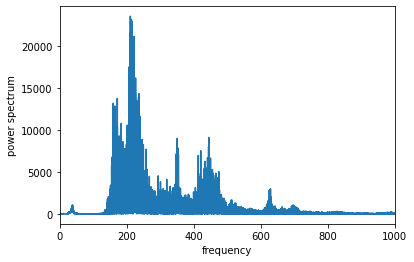

['women', 211.0202202322809]
------------------------------------------


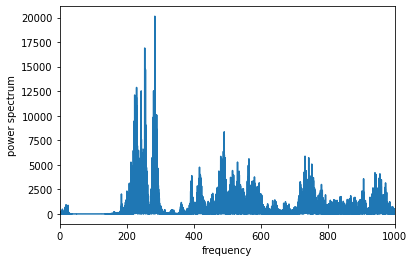

['women', 283.72423274871784]
------------------------------------------


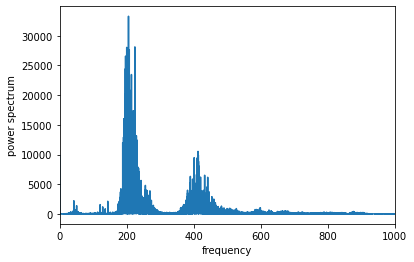

['women', 205.48636114308582]
------------------------------------------


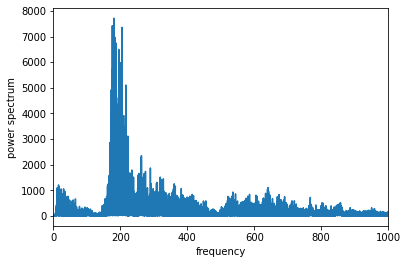

['women', 181.34491467004406]
------------------------------------------


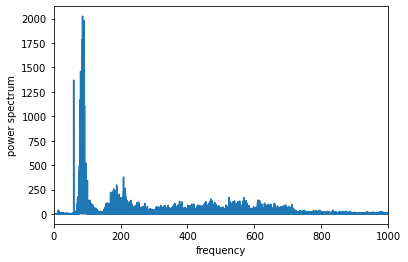

['man', 86.5617607694223]
------------------------------------------
{'voices/v8.wav': ['man', 149.89958292986054], 'voices/v9.wav': ['women', 180.00235293348715], 'voices/v10.wav': ['women', 218.0506359746872], 'voices/v11.wav': ['man', 128.9516661222912], 'voices/v2.wav': ['man', 50.047482262404], 'voices/v3.wav': ['man', 131.32155104194143], 'voices/v1.wav': ['man', 110.43235723920863], 'voices/v0.wav': ['women', 211.0202202322809], 'voices/v4.wav': ['women', 283.72423274871784], 'voices/v5.wav': ['women', 205.48636114308582], 'voices/v7.wav': ['women', 181.34491467004406], 'voices/v6.wav': ['man', 86.5617607694223]}


In [6]:
main("voices")


# Noise cancellation

## 1) Spectral Subtraction Algorithm

Spectral subtraction is a method for restoration of the power or the magnitude spectrum of a signal observed in additive noise, through subtraction of an estimate of the average noise spectrum from the noisy signal spectrum. The noise spectrum is estimated, and updated, from the periods when the signal is absent and only the noise is present. The assumption is that the noise is a stationary or a slowly varying process, and that the noise spectrum does not change significantly in-between the update periods. For restoration of time-domain signals, an estimate of the instantaneous magnitude spectrum is combined with the phase of the noisy signal, and then transformed via an inverse discrete Fourier transform to the time domain. In terms of computational complexity spectral subtraction is relatively inexpensive. However, due to random variations of noise, spectral subtraction can result in negative estimates of the short-time magnitude or power spectrum. The magnitude and power spectrum are non-negative variables, and any negative estimate of these variables should be mapped into a non-negative value. This nonlinear rectification process distorts the distribution of the restored signal. The processing distortion becomes more noticeable as the signal to noise ratio decreases.

spectral subtraction methods: 

- Basic spectral subtraction algorithm
- Spectral Subtraction with over subtraction
- Non–linear Spectral Subtraction
- Multiband Spectral Subtraction 
- Minimum Mean Square Error Spectral Subtraction Algorithm
- Selective Spectral Subtraction Algorithm

to evaluate the efficiency of these methods, we consider SNR, PESQ, plots, and listening tests.
overally all these methods significantly reduce noise in input signal.

In [7]:
from math import sqrt
from numpy import random
from librosa import stft, istft

## 2) Implementing Algorithm

In [8]:
def spectral_subtraction(sampling_rate, noisy_signal, noise):
    # compute fourier series and it's absolute value
    # for both noisy signal and noise
    fft_noisy_signal = (stft(noisy_signal))
    absolute_value_fft_noisy_signal = np.abs(fft_noisy_signal)
    absolute_value_fft_noise = np.abs(stft(noise))
    # each value in fourier series can be represented as a complex number r e ^ (iƟ)
    # here a = Ɵ
    # and b = e ^ iƟ
    a = np.angle(fft_noisy_signal)
    b = np.exp(1.0j * a)
    # get average of fourier series absolutes
    average_fft_noise = np.mean(absolute_value_fft_noise, axis=1)
    # calculate denoisy signal (we reshape average_fft_noise as vector to enable vector arithmeticss)
    denoisySignal = istft(( absolute_value_fft_noisy_signal - average_fft_noise.reshape((average_fft_noise.shape[0], 1)) ) * b )
    denoisySignal_type = denoisySignal.astype(np.int16)
    wavfile.write('Denoise.wav', sampling_rate,denoisySignal_type)

## 3) AWGN noise

In [9]:
def AWGN(sampling_rate , data , SNR) :
    Root_mean_Square_signal = sqrt(np.mean(data**2))
    Root_mean_Square_noise = sqrt(Root_mean_Square_signal**2/(pow(10,SNR/10)))
    noise =(random.normal(0, Root_mean_Square_noise, data.shape[0]) ).astype(np.float32)
    noisy_signal = np.add(data, noise)
    wavfile.write('noisy.wav', sampling_rate, noisy_signal.astype(np.int16))
    return noisy_signal, noise

In [10]:
def craete_plot_signals(filename,title):
    sampling_rate, complete_data = wavfile.read(filename)
    data = complete_data.astype(np.float32)
    t = np.linspace(0, n = data.shape[0] / sampling_rate , data.shape[0])
    plt.plot(t, data)
    plt.xlabel("t")
    plt.ylabel("signal_magnitude")
    plt.title(title)
    plt.show()

In [11]:
sampling_rate, comlete_data = wavfile.read("Test.wav")
data = comlete_data.astype(np.float32)
noisy_signal, noise = AWGN(sampling_rate, data, 1)
spectral_subtraction(sampling_rate, noisy_signal, noise)

we use audio file and add random noise data to it. afterwards we save the noisy file and draw plots with it.

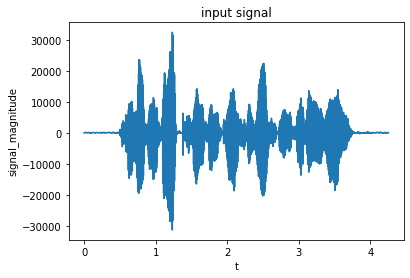

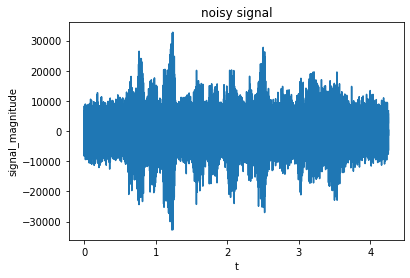

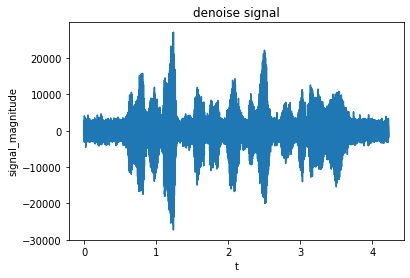

In [12]:
craete_plot_signals('Test.wav','input signal')
craete_plot_signals('noisy.wav','noisy signal')
craete_plot_signals('Denoise.wav','denoise signal')